In [2]:
# import findspark and os and let findspark find all the environment variables
import findspark
import os
findspark.init()


# Before you create the SparkSession, you need to add a new environment variable 
# to tell pyspark where the graphframes library is
SUBMIT_ARGS = "--packages graphframes:graphframes:0.7.0-spark2.4-s_2.11 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import udf

# Create the SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("graphx-lab").getOrCreate()

# import additional libraries
from graphframes import *
import hashlib

In [28]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import linear_model

In [4]:
sc = spark.sparkContext
sc.setCheckpointDir('.')

In [57]:
def hashnode(x):
    return hashlib.sha1(x.encode("UTF-8")).hexdigest()[:8]

hashnode_udf = udf(hashnode)

def path_list(path, size):
    ps = []
    for s in size:
        ps.append([path+'/part-'+str(i).zfill(5) for i in range(s)])
#     print(ps)
    return ps

def build_graphs(path, size):
    d = {}
    for s, l in zip(size,path_list(path, size)):
        df = spark.read.load(l,format="csv", sep="\t", inferSchema="true", header="false")
        df = df.withColumnRenamed('_c0', 'parentTLD').withColumnRenamed('_c1', 'childTLD').filter("parentTLD is not null and childTLD is not null")
        df = df.drop_duplicates()
        aggcodes = df.select("parentTLD","childTLD").rdd.flatMap(lambda x: x).distinct()
        vertices = aggcodes.map(lambda x: (hashnode(x), x)).toDF(["id","name"])
        edges = df.select("parentTLD","childTLD")\
        .withColumn("src", hashnode_udf("parentTLD"))\
        .withColumn("dst", hashnode_udf("childTLD")).select("src","dst")
        vertices.cache()
        edges.cache()
        d[s] = GraphFrame(vertices, edges), vertices, edges
#         print(edges.count())
    return d

def evd(graphs, size=[1,2,4,8]):
    nes = []
    nvs = []
    dens = []
    for s in size:
        graph,vertices,edges = graphs[s]
        
        n_v = vertices.count()
        n_e = edges.count()
        
        nes.append(n_e)
        nvs.append(n_v)
        dens.append(n_e / (n_v*(n_v-1)))
    return nes, nvs, dens

# from pyspark.sql import SQLContext
# sqlContext = SQLContext(sc)
def connected_components(graphs, sizes=[1,2,3]):
    n_comp = []
    n_strcomp = []
    for s in size:
        graph,vertices,edges = graphs[s]
    
        result = graph.connectedComponents()
        result1 = graph.stronglyConnectedComponents(maxIter = 10)
        n_comp.append(result.select("component").distinct().count())
        n_strcomp.append(result1.select("component").distinct().count())

    return n_comp, n_strcomp


def lpa():
    
    return None

In [23]:
start = time.time()
d = build_graphs('s3://502lab3/proj512', [1,2,4,8,16,32,64,128,256,512])
time.time() - start

120637
227738
443994
835269
1559110
2756631
5142550
8969187
15272886
25598815


786.8599972724915

In [39]:
np.log2(size)**3

array([  0.,   1.,   8.,  27.,  64., 125., 216., 343., 512., 729.])

In [27]:
size = [1,2,4,8,16,32,64,128,256,512]
nes, nvs, nds = evd(d, size)

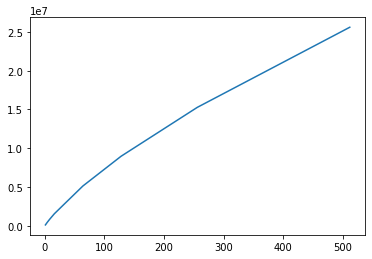

In [73]:
plt.plot(size, nes)

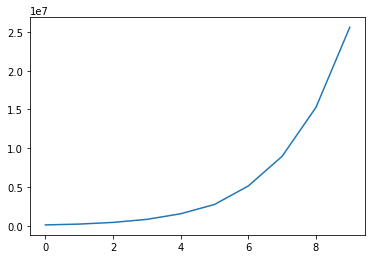

In [81]:
plt.plot(np.log2(size), nes)

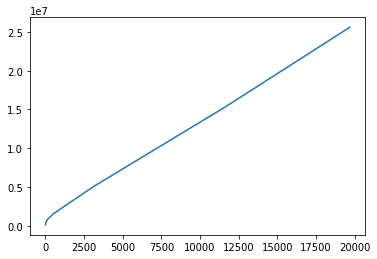

In [88]:
plt.plot(np.log2(size)**4.5, nes)

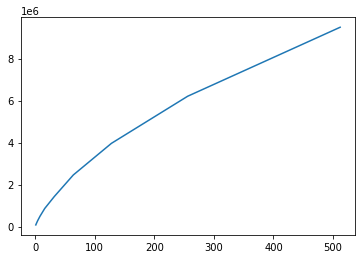

In [71]:
plt.plot(size, nvs)

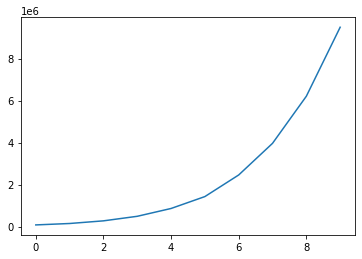

In [82]:
plt.plot(np.log2(size), nvs)

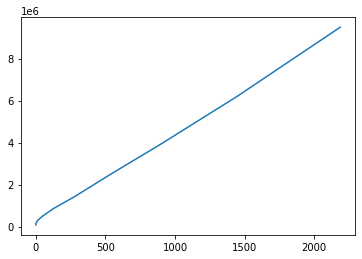

In [85]:
plt.plot(np.log2(size)**3.5, nvs)

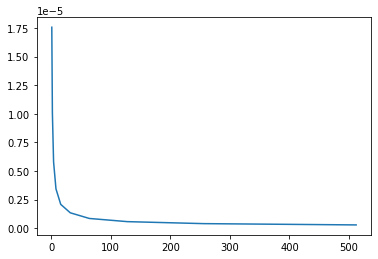

In [89]:
plt.plot(size, nds)

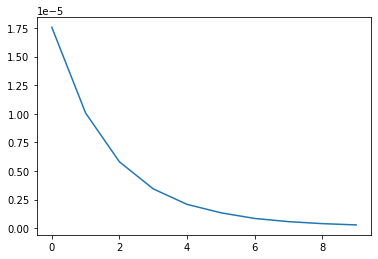

In [90]:
plt.plot(np.log2(size), nds)

/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


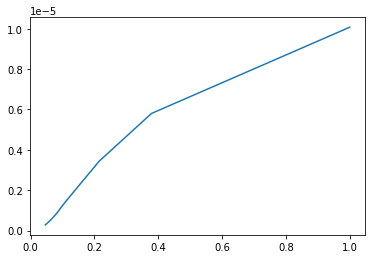

In [113]:
plt.plot(1/(np.log2(size)**1.4), nds)

In [78]:
ncc, nscc = connected_components(d, [1,2])

KeyboardInterrupt: 

In [8]:
density('s3://502lab3/proj20', [1,2,4,8,16])

[1.7194272815919763e-05,
 9.909619814694752e-06,
 5.738039507889342e-06,
 3.3633506785714227e-06,
 2.046093259947005e-06]

In [ ]:
path = 's3://502lab3/proj512'
size = [1,2,4,8]
graph_dict = build_graphs(path, size)
density(graph_dict, size)

In [20]:
graph10,vertices10,edges10 = build_graph(df10)
graph20,vertices20,edges20 = build_graph(df20)

In [22]:
print('number of v:',vertices20.count())
print('number of e:',edges20.count())

number of v: 1059592
number of e: 1978621


In [24]:
start_time = time.time()
result10 = graph10.labelPropagation(maxIter=5)
print(time.time() - start_time)
result20 = graph20.labelPropagation(maxIter=5)
print(time.time() - start_time)
# result.cache()
# result.show(5)
# result.groupby('label').count().filter('count==362').orderBy("count", ascending=True).show()
# print(result.groupby('label').count().drop_duplicates(['count']).count())
# print(result.groupby('label').count().count())
# result.count()
# vertices.distinct().count()

6123.049489736557


KeyboardInterrupt: 

In [ ]:
# np.unique()
result.groupby('label').count().withColumnRenamed('count', 'community_size').groupby('community_size').count().orderBy("community_size", ascending=True).show()
result.groupby('label').count().withColumnRenamed('count', 'community_size').groupby('community_size').count().orderBy("community_size", ascending=False).show()
result.filter('label==386547056837').show(truncate=False)

In [ ]:
start_time = time.time()
cc10 = graph10.connectedComponents()
print(time.time() - start_time)
cc20 = graph20.connectedComponents()
print(time.time() - start_time)

In [ ]:
start_time = time.time()
scc10 = graph10.stronglyConnectedComponents(maxIter=10)
print(time.time() - start_time)
scc20 = graph20.stronglyConnectedComponents(maxIter=10)
print(time.time() - start_time)

+------------+-----+
|       label|count|
+------------+-----+
|386547056837|  362|
+------------+-----+



+--------+------------------------------------+------------+
|id      |name                                |label       |
+--------+------------------------------------+------------+
|650d9a6d|hadt.ru                             |386547056837|
|be3941d6|mmonix.ru                           |386547056837|
|858e80aa|gamersofelements.de                 |386547056837|
|03875694|ejms.kejari-berau.go.id             |386547056837|
|79192b35|bbs.missionbayseafood.co.nz         |386547056837|
|fe8cefa5|blaulichtforum.at                   |386547056837|
|7e66855a|bb.zdenekskulinek.cz                |386547056837|
|b13ac782|clubber.co.uk                       |386547056837|
|4982c708|forum.lekhzena.tn                   |386547056837|
|58bc1672|ishahe.net                          |386547056837|
|60f59818|yarnews163.ru                       |386547056837|
|35206781|coinping.co                         |386547056837|
|f3bce3af|bestcity.if.ua                      |386547056837|
|715fdae8|forum.marycoin

In [ ]:
def indegree(dataframe, website=['twitter.com'], sizes=[1,2,3]):
    '''input: dataframe, list: websites tlds; list: number of files
       output: dataframe
+------------+--------+---------------------------+
|website     |size_1  |sizs_2    |sizse_3             |
+------------+--------+---------------------------+
|twitter.com |1       | 100      |
|05f4dd35    |1       |          |
|033e4ad5    |1       |          |
|00615816    |1       |          |
|034274db    |1       |          |
+-------------+--------+---------------------------+
    '''
    return None

In [ ]:
indegree([2,4,8,16,32,64,128,256,512,1024])

In [ ]:
indegree_df = indegree(df, ['twitter.com', 'baidu,com', 'google'], [2,4,8,16])
indegree_df.show()

In [ ]:
def outdegree(dataframe, website=['twitter.com'], sizes=[1,2,3]):
    '''input: dataframe, list: websites tlds; list: number of files
       output: dataframe
+------------+--------+---------------------------+
|website     |size_1  |sizs_2    |  sizse_3             |
+------------+--------+---------------------------+
|twitter.com |1       | 100      |
|05f4dd35    |1       |          |
|033e4ad5    |1       |          |
|00615816    |1       |          |
|034274db    |1       |          |
+------------+--------+---------------------------+
    '''
    return None

In [ ]:
def connected_components(dataframe, sizes=[1,2,3]):
    '''input: dataframe, list: number of files
       output: dataframe
+------------+--------+---------------------------+
|size        |number of componemts  |sizs_2    |  sizse_3             |
+------------+--------+---------------------------+
|1           |1                     | 100      |
|2           |1                     |          |
|3           |1                     |          |

    '''
    return None

In [ ]:
def analyze_graph(path='test', size=[2,4,8,16]):
    d = {}
    
    d['indeg_df']  = indegree(size=size)
    d['ourdeg_df'] = outdegree(size=size)
    d['cc'] = connected_components(size=size)
    
    return d

In [6]:
df.cache()

DataFrame[_c0: string, _c1: string]

In [4]:
df.show(10)

+---------+-----------------+
|      _c0|              _c1|
+---------+-----------------+
|002104.cn|    hd.hstong.com|
|002104.cn|   stock.stcn.com|
|002104.cn|  upload.stcn.com|
|002104.cn|  upload.stcn.com|
|002104.cn|  upload.stcn.com|
|002104.cn|  upload.stcn.com|
|002446.cn|    hd.hstong.com|
|003145.cn|qile.qiquting.com|
|003145.cn|qile.qiquting.com|
|003991.cn|qile.qiquting.com|
+---------+-----------------+
only showing top 10 rows



In [8]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)



In [7]:
df.count()

3678351

In [9]:

df.show(5)

+---------------+------------------+
|      parentTLD|          childTLD|
+---------------+------------------+
|24hourebook.com|       jlsl.gov.cn|
|   350.xn--p1ai|   connect.mail.ru|
|   350.xn--p1ai|zakladki.yandex.ru|
|        363v.cn|      pk105555.com|
|      87nara.kr|       iampine.com|
+---------------+------------------+
only showing top 5 rows



In [16]:
df.count()

904373

In [13]:

print(aggcodes.count())
aggcodes.top(10)

['바로잡기.com',
 '무지안내.net',
 '맥가이버피아노.com',
 '라포끌레르.kr',
 '더풋샵.net',
 '나로.한국',
 '강원곳간.com',
 '非常靠谱.com',
 '陕西文化网.中国',
 '陕西文化网.com']

+--------+--------------------+
|      id|                name|
+--------+--------------------+
|64810973|img514.imageshack.us|
|465806fb|         twitter.com|
|247e1a71|  beautifulshoes.org|
|5584fcd3|guccihandbagsoutl...|
|09651082|       bufengcong.cn|
+--------+--------------------+
only showing top 5 rows



In [18]:


edges.show(5)

+--------+--------+
|     src|     dst|
+--------+--------+
|a955fc5f|ec156376|
|2b778455|b1045852|
|2b778455|a49aa74f|
|e8b6308e|ebd38990|
|b0451246|3fcdbfdc|
+--------+--------+
only showing top 5 rows



In [20]:
graph.vertices.show(5)
graph.edges.show(5)

+--------+--------------------+
|      id|                name|
+--------+--------------------+
|64810973|img514.imageshack.us|
|465806fb|         twitter.com|
|247e1a71|  beautifulshoes.org|
|5584fcd3|guccihandbagsoutl...|
|09651082|       bufengcong.cn|
+--------+--------------------+
only showing top 5 rows

+--------+--------+
|     src|     dst|
+--------+--------+
|a955fc5f|ec156376|
|2b778455|b1045852|
|2b778455|a49aa74f|
|e8b6308e|ebd38990|
|b0451246|3fcdbfdc|
+--------+--------+
only showing top 5 rows



In [22]:
graph.inDegrees.join(vertices, on="id")\
.orderBy("inDegree", ascending=False).show(20, False)
graph.outDegrees.join(vertices, on="id")\
.orderBy("outDegree", ascending=False).show(20, False)

+--------+--------+---------------------------+
|id      |inDegree|name                       |
+--------+--------+---------------------------+
|03111be4|1       |bigjeans.co.kr             |
|05f4dd35|1       |kitp.ucsb.edu              |
|033e4ad5|1       |livefutbol.com             |
|00615816|1       |weekendhotel.blog          |
|034274db|1       |vusurscene.com             |
|0088f064|1       |topfreizeit.de             |
|035a0f78|1       |donemd.cn                  |
|00ade0f6|1       |printshop.co.kr            |
|05d51afe|1       |ehiln67n99.353qt.cn        |
|0380adbc|1       |kaatru.in                  |
|00bf6f09|1       |hg8868fdzs71.cn.com        |
|03ac6afd|1       |nmyk.kingdns.in            |
|0133f1a7|1       |qualitywellnessresorts.nl  |
|03fdc338|1       |sarquest.ru                |
|01804c23|1       |dosenhor.com               |
|0404cf3e|1       |167.114.119.122:9676       |
|019a4650|1       |silkroomthailand.com       |
|04128bf0|1       |openparachute.wordpre

In [35]:
# result = graph.connectedComponents()
result.select("id", "component").groupby('component').count().orderBy("count", ascending=False).show()

+-----------+------+
|  component| count|
+-----------+------+
|          0|459137|
|        116|  3499|
|       1064|   982|
|         75|   622|
|       1387|   519|
|        732|   451|
|        339|   335|
|       2349|   308|
|       1238|   277|
|        184|   244|
|        516|   241|
| 8589936039|   239|
|        856|   228|
|       2061|   226|
|       2398|   226|
|       1301|   180|
| 8589934891|   178|
|       2506|   172|
|       1666|   168|
|34359739686|   135|
+-----------+------+
only showing top 20 rows



In [36]:
result2 = graph.stronglyConnectedComponents(maxIter=10)
result2.select("id", "component").orderBy("component").show()

+--------+---------+
|      id|component|
+--------+---------+
|002c9569|        0|
|008c2d9c|        1|
|00927e3f|        2|
|00947a5b|        3|
|00acfdcd|        4|
|00ad5293|        5|
|00c6dae1|        6|
|00d7cab4|        7|
|010b6f81|        8|
|010ba2b9|        9|
|014f3a50|       10|
|01703f81|       11|
|0191598e|       12|
|01bc71ce|       13|
|01c087cc|       14|
|01d4353c|       15|
|01dfa2cd|       16|
|0227d662|       17|
|02341045|       18|
|0241ee58|       19|
+--------+---------+
only showing top 20 rows



In [ ]:
result3 = g.labelPropagation(maxIter=5)
result4.select("id", "label").show()

In [ ]:
results = g.pageRank(resetProbability=0.15, tol=0.01)
results.vertices.select("id", "pagerank").show()
results.edges.select("src", "dst", "weight").show()

In [1]:
spark.stop()

NameError: name 'spark' is not defined